In [1]:
from plato.environment import Environment

In [2]:
config = {
  "whites":{
    "params":{
    "n_white_infantry":5,
    "n_white_vehicle":0,
    "n_white_drone":1},
    "init":"SE"
  },

  "blacks":{
    "params":{
    "n_black_infantry":1,
    "n_black_vehicle":0,
    "n_black_drone":0},
    "init":"NW"
  }
}

In [3]:
sim = Environment(config, shape=(8,8), time_limit=2**7)

In [4]:
obs = sim.reset()

In [5]:
from plato.objective.spatiotemporal.engage_objective import EngageObjective
sim.objectives = [EngageObjective(targets=sim.blacks.values())]

In [6]:
minimap = sim.observation(sim.whites, negative=None)
minimap.shape

(25, 8, 8)

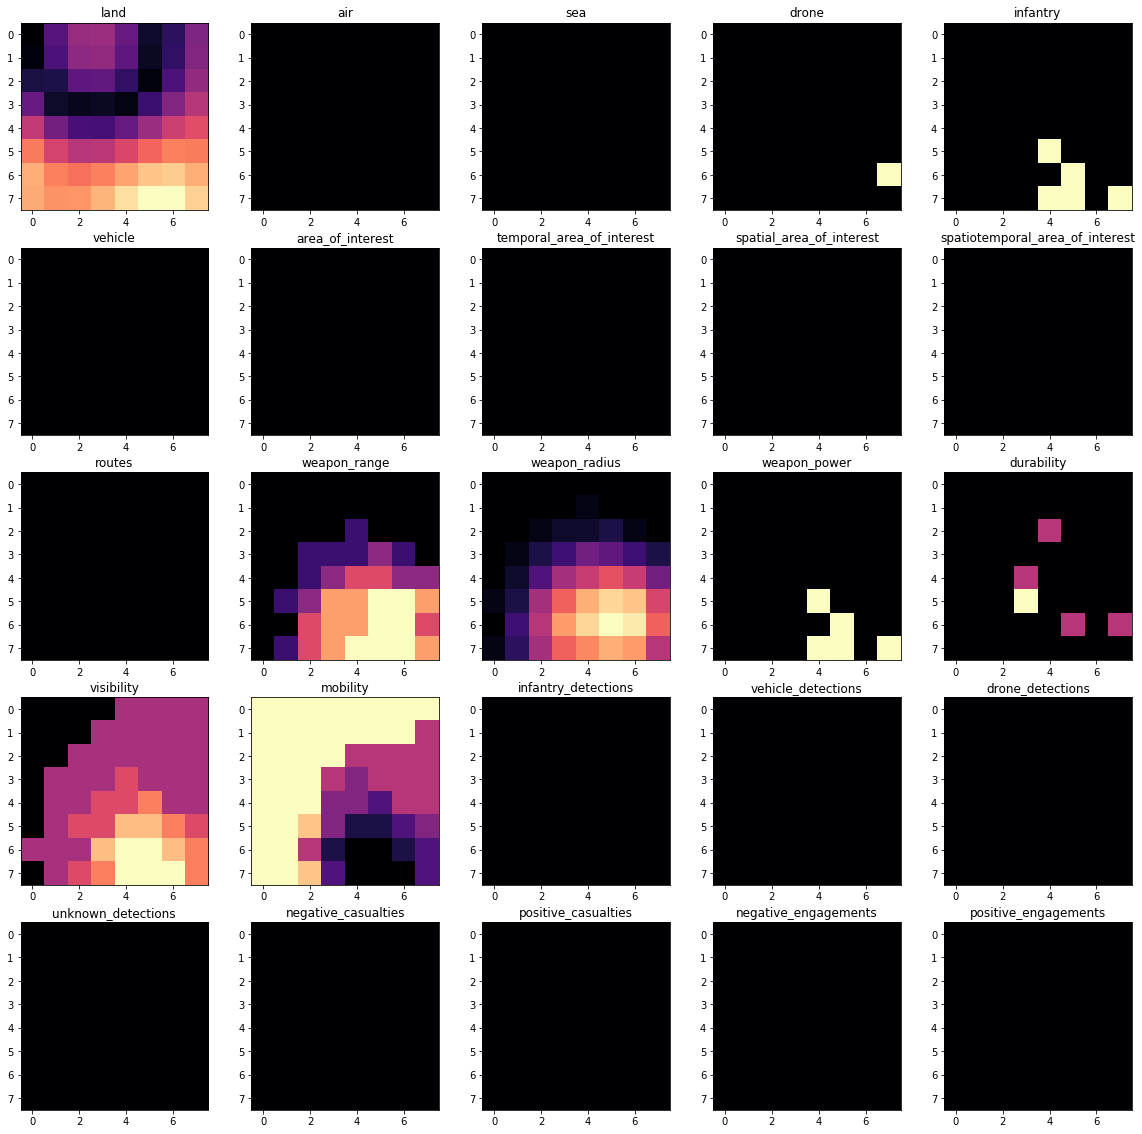

In [7]:
import numpy as np, matplotlib.pyplot as mp
from plato.features import global_features
fig,ax = mp.subplots(5,5, figsize=(20,20))
for itr,(name,feat) in enumerate(zip(global_features, minimap)):
    i,j = np.unravel_index(itr,(5,5))
    ax[i,j].set_title(name)
    ax[i,j].imshow(feat, cmap='magma')
mp.show()

In [8]:
import torch as th
class EntityTypeController(th.nn.Module):
    def __init__(self, inch, ouch, nonlin=th.nn.LeakyReLU(2e-1)):
        super().__init__()   
        self.inch, self.ouch = inch, ouch
        self.encoder = th.nn.ModuleList([
        th.nn.Conv2d(inch, 64, kernel_size=minimap.shape[-1]), nonlin])
        
        self.output = th.nn.Sequential(
        th.nn.Linear(self.features(), 64),
        nonlin,
        th.nn.Dropout(0.1),
        th.nn.Linear(64, ouch))
        
    def features(self):
        x = th.randn((1,self.inch,*minimap.shape[1:]))
        for layer in self.encoder: x = layer(x)
        return x.view(1,-1).size(-1)
    
    def __call__(self, x, verbose=False):
        for layer in self.encoder:
            x = layer(x)
            if verbose: print(x.size())
        x = x.view(-1)
        if verbose: print(x.size())
        y = self.output(x)
        if verbose: print(y.size())
        return y

In [9]:
import random
infantry_entity = random.choice([ent for ent in list(sim.whites.values()) if ent.entity_type == 'infantry'])
infantry_controller = EntityTypeController(minimap.shape[0], infantry_entity.n_actions)
infantry_controller

EntityTypeController(
  (encoder): ModuleList(
    (0): Conv2d(25, 64, kernel_size=(8, 8), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (output): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=42, bias=True)
  )
)

In [10]:
infantry_controller(th.randn(1,*minimap.shape), verbose=True)

torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 1, 1])
torch.Size([64])
torch.Size([42])


tensor([-0.0386, -0.2640, -0.0284,  0.1987, -0.2335, -0.0331,  0.1518,  0.0457,
         0.0574,  0.1305,  0.0095, -0.0720, -0.1623, -0.0134,  0.0855,  0.0322,
        -0.2047, -0.1388,  0.0543,  0.4517,  0.0027,  0.0353, -0.1967, -0.1220,
        -0.0940,  0.0174,  0.1465,  0.0674,  0.0294,  0.0554, -0.0604,  0.0904,
         0.2435,  0.1317,  0.0773,  0.1271, -0.0700, -0.1790, -0.0666,  0.2490,
        -0.1022, -0.0513], grad_fn=<AddBackward0>)

In [11]:
import collections
class Memory(object):
    def __init__(self, capacity=1):
        self.wipe(capacity)
        
    def wipe(self, capacity=1):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, sprime, aprime, terminal):
        state  = np.asarray(state).astype(np.float32)
        action = np.asarray(action).astype(np.float32)
        reward = np.asarray(reward).astype(np.float32)
        sprime = np.asarray(sprime).astype(np.float32)
        aprime = np.asarray(aprime).astype(np.float32)
        terminal = np.asarray(terminal).astype(np.float32)
        self.buffer.append((state, action, reward, sprime, aprime, terminal))

    def save(self, saver):
        np.save(saver, np.asarray(self.buffer))

    def sample(self, bsize=1):
        s,a,r,s_,a_,t = zip(*random.sample(self.buffer, bsize))
        return np.array(s), np.array(a), np.array(r), np.array(s_), np.array(a_), np.array(t)

    def __len__(self):
        return len(self.buffer)

In [12]:
infantry_actions = [ent for ent in sim.whites.values() if ent.entity_type == 'infantry'][0].n_actions
drone_actions = [ent for ent in sim.whites.values() if ent.entity_type == 'drone'][0].n_actions

print('infantry actions:', infantry_actions)
print('drone actions:', drone_actions)

infantry actions: 42
drone actions: 81


In [13]:
import torch as th
from torch.autograd import Variable

lossf = th.nn.SmoothL1Loss()

def on_policy(controller, optim, s,a,r,s_,a_,t):
    s = th.from_numpy(s).float()
    a = th.from_numpy(a).float()
    r = th.from_numpy(r).float()
    s_= th.from_numpy(s_).float()
    a_= th.from_numpy(a_).float()
    t = th.from_numpy(t).float()
    
    optim.zero_grad()

    Qvalue = controller( s)
    Qvalue = Qvalue.unsqueeze(0)

    Qprime = controller(s_)
    Qprime = Qprime.unsqueeze(0)
        
    Qvalue = Qvalue.gather(1, a.unsqueeze(1).long()).squeeze(1)
    Qprime = Qprime.gather(1,a_.unsqueeze(1).long()).squeeze(1)

    Qvalue = Variable(Qvalue, requires_grad=True)
    Qprime = Variable(Qprime, requires_grad=False)

    Qexpect = r + 9e-1 * Qprime * (1 - t)

    loss = lossf(Qvalue, Qexpect)

    loss.backward()

    optim.step()
    return loss.item()

In [17]:
class OnPolicyController(object):
    def __init__(self):
        super().__init__()
        self.policy = lambda logits:logits.max(-1)[1]
        self.memory = Memory()
        
        ch = 1 + minimap.shape[0]
        
        self.infantry_controller = EntityTypeController(ch, infantry_actions)
        self.drone_controller = EntityTypeController(ch, drone_actions)
        
        self.entity_types = ['infantry','drone']
    
        self.controllers = {
            'infantry':self.infantry_controller,
            'vehicle':None,
            'drone'  :self.drone_controller
        }
        
        self.infantry_optim = th.optim.Adam(self.controllers['infantry'].parameters(), amsgrad=True)
        self.drone_optim = th.optim.Adam(self.controllers['drone'].parameters(), amsgrad=True)
        
        self.optimizers = {
            'infantry':self.infantry_optim,
            'vehicle':None,
            'drone':self.drone_optim
        }
        
        self.filter_entities= lambda entities:{k:v for k,v in entities.items() \
                                               if v.operational and v.entity_type in self.entity_types}
        self.filter_actions = lambda entities:{k:v.random_action() for k,v in entities.items() if v.operational}
    
    def localize_observation(self, entity, minimap):
        identity = np.zeros((*minimap.shape[1:],))
        identity[entity.xy[0],entity.xy[1]] = 1
        identity = np.expand_dims(identity,axis=0)
        return np.concatenate([identity, minimap],axis=0)
            
    def update(self, entity, s, a, r, s_, a_, t):
        controller = self.controllers[entity.entity_type]
        optim = self.optimizers[entity.entity_type]
        loss = on_policy(controller, optim, s,a,r,s_,a_,t)
        return loss
        
    def retain(self,s,entities,a,r,s_,entities_,a_,t):
        entities = self.filter_entities(entities)
        entities_= self.filter_entities(entities_)
        losses = []
        for (entity, action, entity_, aprime) in zip(entities.values(),a.values(),entities_.values(),a_.values()):
            state = self.localize_observation(entity, s)
            sprime = self.localize_observation(entity_,s_)
            self.memory.push(state, action.detach().numpy(), r, sprime, aprime.detach().numpy(), t)
            self.update(entity,*self.memory.sample(bsize=1))
            self.memory.wipe()
        return losses
        
    def __call__(self, entities, minimap, verbose=False):
        self.entities = self.filter_entities(entities)
        actions = self.filter_actions(entities)

        for id_,entity in self.entities.items():
            controller = self.controllers[entity.entity_type]
            x = self.localize_observation(entity, minimap)
            x = th.from_numpy(x).float().unsqueeze(0)
            logits = controller(x)
            actions[id_] = self.policy(logits)
            
        return actions
    
white_controller = OnPolicyController()
black_controller = OnPolicyController()

In [18]:
import copy, tqdm

def play(white, black):
    sim.reset()
    bar = tqdm.tqdm_notebook(total=sim.time_limit)
    
    loss = None
    
    rewards = []
    whites,wprime = None, None
    terminal = False
    while not terminal:
        entities,enemies = copy.deepcopy(sim.whites), copy.deepcopy(sim.blacks)

        white_obs = sim.observation(sim.whites)
        black_obs = sim.observation(sim.blacks)
        
        wprime = white(sim.whites, white_obs)
        bprime = black(sim.blacks, black_obs)
        
        _, reward, terminal, metadata = sim.step(wprime, bprime)

        wprime_obs = sim.observation(sim.whites)

        if wprime is not None and whites is not None:
            white.retain(white_obs, entities, whites, reward, wprime_obs, sim.whites, wprime, terminal)

        whites,blacks = wprime,bprime
        wprime_obs = white_obs
        bprime_obs = black_obs
        rewards.append(reward)
        bar.update(1)
        if loss: bar.set_description('Loss: {:.8f}'.format(loss))
                
    print( 'white operational status')
    for k,v in sim.whites.items(): print('{:12}: {}'.format(k, v.operational))
    print('\nblack operational status')
    for k,v in sim.blacks.items(): print('{:12}: {}'.format(k, v.operational))   
    
    return metadata['status'], np.sum(rewards)

In [ ]:
threshold = 0.55
epochs, games = 10,10

wins,losses,draws = 0,0,0
w,l,d = [],[],[]
returns = 0
cummulative = []

ebar = tqdm.tqdm_notebook(range(1,1+epochs))
for epoch in ebar:
    ebar.set_description('Epoch {}'.format(epoch))
    gbar = tqdm.tqdm_notebook(range(1,1+games))
    for game in gbar:
        gbar.set_description('Game {}: {}-{}-{}, Rewards: {}'.format(game,wins,losses,draws,returns))
        outcome, returns = play(white_controller, black_controller)
        if outcome == 'success':
            wins+=1
            print('\n✅ mission criteria: SUCCESS')
        if outcome == 'neutral':
            draws+=1
            print('\n🏳 mission criteria: NEUTRAL')
        if outcome == 'failure':
            losses+=1
            print('\n❌ mission criteria: SUCCESS')
        w.append(wins)
        d.append(draws)
        l.append(losses)
    streak = wins
    if threshold <= (streak / games):
        for (wcontroller,bcontroller) in zip(white_controller.controllers.values(), black_controller.controllers.values()):
            bcontroller.load_state_dict(wcontroller.state_dict())
    streak = 0
    if epoch and epoch % 100 == 0:
        fig,ax = mp.subplots(figsize=(17,7))
        ax.plot(w, lw=2, label='Wins')
        ax.plot(d, lw=2, label='Draws')
        ax.plot(l, lw=2, label='Losses')
        mp.legend()
        mp.show()

white operational status
WATERLOO    : True
TOMBSTONE   : True
ANAHEIM     : True
QUEBEC      : True
NEEDLES     : True
LIMA        : True

black operational status
unknown_0   : True

🏳 mission criteria: NEUTRAL


white operational status
INDIA       : True
PHOENIX     : True
COLORADO    : True
INDEPENDENCE: True
CHARLIE     : True
SEAGULL     : True

black operational status
unknown_0   : True

🏳 mission criteria: NEUTRAL


white operational status
SEAGULL     : True
HYANNIS     : True
ECHO        : True
INDIA       : True
ROMEO       : True
NOVEMBER    : True

black operational status
unknown_0   : False

✅ mission criteria: SUCCESS


white operational status
LITTLEROCK  : True
HOPE        : True
HONOLULU    : True
CALEXICO    : True
TYPHOON     : True
MAHAN       : True

black operational status
unknown_0   : True

🏳 mission criteria: NEUTRAL


white operational status
LAGUNA      : True
TOKYO       : True
PHOENIX     : True
NEWYORK     : True
AMERICA     : True
TOMBSTONE   : True

black operational status
unknown_0   : False

✅ mission criteria: SUCCESS


white operational status
YANKEE      : True
ROMEO       : True
INDIA       : True
DENVER      : True
BUFFALO     : True
INDEPENDENCE: True

black operational status
unknown_0   : False

✅ mission criteria: SUCCESS


white operational status
TOKYO       : True
ECHO        : True
SPALDING    : True
GUNSTONHALL : True
HOPE        : True
BISBEE      : True

black operational status
unknown_0   : True

🏳 mission criteria: NEUTRAL


white operational status
EUREKA      : True
ATLANTA     : True
GADSDEN     : True
IPSWICH     : True
MARYLAND    : True
WINSLOW     : True

black operational status
unknown_0   : False

✅ mission criteria: SUCCESS


white operational status
OCEANCITY   : True
STOCKDALE   : True
THESULLIVANS: True
ROMEO       : True
TYPHOON     : True
PHOENIX     : True

black operational status
unknown_0   : False

✅ mission criteria: SUCCESS


white operational status
INDIA       : True
TEMPEST     : True
CHARLIE     : True
LEYTEGULF   : True
LITTLEROCK  : True
MONSOON     : True

black operational status
unknown_0   : True

🏳 mission criteria: NEUTRAL
